In [1]:
# Section 1 - Setup (ensure each of these are installed within your environment prior to importing)
import os
import re
import string
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import word_tokenize
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

In [2]:
# Section 2 - Datasets (load in datasets of interest); ensure these are located in current working directory
df_codes = pd.read_csv("UNSD — Methodology.csv", sep=";") # UNSD country codes; link: https://unstats.un.org/unsd/methodology/m49/overview
df_gini = pd.read_csv("economic-inequality-gini-index.csv") # Gini-coefficient data; link: https://archive.ourworldindata.org/20250919-110751/grapher/economic-inequality-gini-index.html
df_happiness = pd.read_excel("Happiness_Report.xls") # Happiness report data; link: https://www.worldhappiness.report/ed/2024/#appendices-and-data

# Merge datasets - goal is to merge on common column (first, merge df_happiness with df_codes on country name and then merge with df_gini using country code)
# Rename df_codes country names to those of df_happiness such that the merging works 
df_codes["Country or Area"] = df_codes["Country or Area"].replace({
    "Bolivia (Plurinational State of)": "Bolivia", 
    'Congo': 'Congo (Brazzaville)', 
    'Democratic Republic of the Congo': 'Congo (Kinshasa)',
    'China, Hong Kong Special Administrative Region': 'Hong Kong S.A.R. of China', 
    'Iran (Islamic Republic of)': 'Iran', 
    'Côte d’Ivoire': 'Ivory Coast', 
    "Lao People's Democratic Republic": 'Laos', 
    'Republic of Moldova': 'Moldova', 
    'Netherlands (Kingdom of the)': 'Netherlands', 
    'Republic of Korea': 'South Korea',
    'Russian Federation': 'Russia', 
    'Syrian Arab Republic': 'Syria', 
    'United Republic of Tanzania': 'Tanzania', 
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 
    'United States of America': 'United States', 
    'Venezuela (Bolivarian Republic of)': 'Venezuela', 
    'Viet Nam': 'Vietnam'})

# Evaluate missing data across df_happiness and df_codes
happiness_countries = set(df_happiness["Country name"].unique()) # Unique country names in df_happiness
codes_countries = set(df_codes["Country or Area"].unique()) # Unique country names in df_codes after replacement
missing_in_codes = happiness_countries - codes_countries # Countries in df_happiness but not in df_codes
print("Countries in df_happiness but not in df_codes:", missing_in_codes) # Note: 'Somaliland region', 'Kosovo', and 'Taiwan' are missing in UNSD codes because they are not recognized as independent states by the UN

# Merge df_happiness and df_codes and clean
temp_merge = pd.merge(df_happiness, df_codes, left_on="Country name", right_on="Country or Area", how="left")

# Assign Kosovo and Taiwan codes manually in merged dataset since they are present in the Gini dataset 
temp_merge.loc[temp_merge["Country name"] == "Kosovo", "ISO-alpha3 Code"] = "OWID_KOS"
temp_merge.loc[temp_merge["Country name"] == "Taiwan Province of China", "ISO-alpha3 Code"] = "TWN"

# Select and order specific columns
temp_merge = temp_merge.rename(columns={"year": "Year"})
temp_merge = temp_merge[['Country name', 'ISO-alpha3 Code', 'Year', 'Region Name', 'Sub-region Name','Least Developed Countries (LDC)','Life Ladder', 
                 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 
                 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 
                 'Positive affect', 'Negative affect']]

# Merge temp_merge with df_gini
# Clean for merging and identify missing data
df_gini_missing_codes = df_gini[df_gini["Code"].isna()]
df_gini_missing_codes_list = df_gini_missing_codes["Entity"].tolist()

country_ids = []
for country in df_gini_missing_codes_list:
    country_ids.append(country.split("(")[0].strip())

print("Countries in df_gini without country codes:", set(country_ids)) # Manually inspect these and determine if it is warranted to input country codes

# Exclude changes to China since data is not missing (rather there are seperate classifications for rural and urban and we are only concerned with the whole country) 
df_gini.loc[df_gini["Entity"] == "Ecuador (urban)", "Code"] = "ECU"
df_gini.loc[df_gini["Entity"] == "Ethiopia (rural)", "Code"] = "ETH"
df_gini.loc[df_gini["Entity"] == "Micronesia (country) (urban)", "Code"] = "FSM"
df_gini.loc[df_gini["Entity"] == "Colombia (urban)", "Code"] = "COL"
df_gini.loc[df_gini["Entity"] == "Argentina (urban)", "Code"] = "ARG"
df_gini.loc[df_gini["Entity"] == "Honduras (urban)", "Code"] = "HND"
df_gini.loc[df_gini["Entity"] == "Rwanda (rural)", "Code"] = "RWA"
df_gini.loc[df_gini["Entity"] == "Suriname (urban)", "Code"] = "SUR"
df_gini.loc[df_gini["Entity"] == "Uruguay (urban)", "Code"] = "URY"
df_gini.loc[df_gini["Entity"] == "Bolivia (urban)", "Code"] = "BOL"

df_gini = df_gini.rename(columns={
    "Code": "ISO-alpha3 Code",
    "Gini coefficient (2021 prices) - Income or consumption consolidated": "Gini coefficient (2021 prices)"})

df_gini = df_gini.dropna(subset=['ISO-alpha3 Code'])

df_gini = df_gini[['Year', 'ISO-alpha3 Code', 'Gini coefficient (2021 prices)']]

merged_df = pd.merge(temp_merge, df_gini, on=['Year', 'ISO-alpha3 Code'], how='left')
merged_df

Countries in df_happiness but not in df_codes: {'Kosovo', 'Taiwan Province of China', 'Somaliland region'}
Countries in df_gini without country codes: {'Argentina', 'Ecuador', 'Ethiopia', 'Micronesia', 'Suriname', 'Uruguay', 'China', 'Colombia', 'Honduras', 'Rwanda', 'Bolivia'}


,Country name,ISO-alpha3 Code,Year,Region Name,Sub-region Name,Least Developed Countries (LDC),Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Gini coefficient (2021 prices)
0,Afghanistan,AFG,2008,Asia,Southern Asia,x,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195,NaN
1,Afghanistan,AFG,2009,Asia,Southern Asia,x,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092,NaN
2,Afghanistan,AFG,2010,Asia,Southern Asia,x,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324,NaN
3,Afghanistan,AFG,2011,Asia,Southern Asia,x,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175,NaN
4,Afghanistan,AFG,2012,Asia,Southern Asia,x,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358,Zimbabwe,ZWE,2019,Africa,Sub-Saharan Africa,NaN,2.693523,7.697755,0.759162,53.099998,0.631908,-0.050874,0.830652,0.658434,0.235354,0.502564
2359,Zimbabwe,ZWE,2020,Africa,Sub-Saharan Africa,NaN,3.159802,7.596050,0.717243,53.575001,0.643303,0.002848,0.788523,0.660658,0.345736,NaN
2360,Zimbabwe,ZWE,2021,Africa,Sub-Saharan Africa,NaN,3.154578,7.656878,0.685151,54.049999,0.667636,-0.079007,0.756945,0.609917,0.241682,NaN
2361,Zimbabwe,ZWE,2022,Africa,Sub-Saharan Africa,NaN,3.296220,7.670073,0.666172,54.525002,0.651987,-0.072935,0.752632,0.640609,0.191350,NaN


In [3]:
# Section 3 - UN speeches dataset & data preprocessing and cleaning
sessions = np.arange(1, 80)
data = []

for session in sessions:
    if session < 10: # Need 0 in front of single digit
        directory = "./TXT/Session "+"0"+str(session)+" - "+str(1945+session)
    else:
        directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), encoding="utf-8") as f: # Specify utf-8 encoding here since the default cp1252 was having issues
            if filename[0]==".": #ignore hidden files
                continue
            splt = filename.split("_")
            data.append([session, 1945+session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Raw Speech'])

# Merge into preexisting merged_df
df_master = pd.merge(merged_df, df_speech, on=['Year', 'ISO-alpha3 Code'], how='left')
df_master = df_master.set_index(["Year", "ISO-alpha3 Code"])

def preprocess(text):
    if not isinstance(text, str):
        return []
    
    words = word_tokenize(text)
    sw = set(stopwords.words("english"))
    extra_noninfo = {"united","nations"} # add any other words to skip
    sw |= extra_noninfo
    # lower-case and strip punctuation
    cleaned = []
    for w in words:
        w = w.lower()
        w = w.translate(str.maketrans('', '', string.punctuation))
        if w and w.isalpha() and w not in sw:
            cleaned.append(w)
    return cleaned

# Apply preprocessing to get a list of meaningful words for each speech and add as a new column to master_df
df_master["Clean Speech"] = df_master["Raw Speech"].apply(preprocess)
df_master

,,Country name,Region Name,Sub-region Name,Least Developed Countries (LDC),Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Gini coefficient (2021 prices),Session,Raw Speech,Clean Speech
Year,ISO-alpha3 Code,,,,,,,,,,,,,,,,,
2008,AFG,Afghanistan,Asia,Southern Asia,x,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195,NaN,63.0,Since the last time we \ngathered here in this...,"[since, last, time, gathered, great, hall, pas..."
2009,AFG,Afghanistan,Asia,Southern Asia,x,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092,NaN,64.0,"First, I would like to \ncongratulate His Exce...","[first, would, like, congratulate, excellency,..."
2010,AFG,Afghanistan,Asia,Southern Asia,x,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324,NaN,65.0,I join previous \nspeakers in congratulating y...,"[join, previous, speakers, congratulating, sir..."
2011,AFG,Afghanistan,Asia,Southern Asia,x,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175,NaN,66.0,I am honoured to be \nhere to read the stateme...,"[honoured, read, statement, president, excelle..."
2012,AFG,Afghanistan,Asia,Southern Asia,x,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919,NaN,67.0,"﻿As we speak today, the world\nis being shaken...","[speak, today, world, shaken, depravity, fanat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,2.693523,7.697755,0.759162,53.099998,0.631908,-0.050874,0.830652,0.658434,0.235354,0.502564,74.0,Allow me to congratulate Mr. Tijjani Muhammad-...,"[allow, congratulate, mr, tijjani, muhammadban..."
2020,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,3.159802,7.596050,0.717243,53.575001,0.643303,0.002848,0.788523,0.660658,0.345736,NaN,75.0,"Your Excellency, Ambassador Volkan Bozkir, Pre...","[excellency, ambassador, volkan, bozkir, presi..."
2021,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,3.154578,7.656878,0.685151,54.049999,0.667636,-0.079007,0.756945,0.609917,0.241682,NaN,76.0,"Your Excellency Abdulla Shahid, President of t...","[excellency, abdulla, shahid, president, sessi..."


In [4]:
# Section 4 - Frequencies of search terms in speeches
# Define search terms
corruption_terms = [
    "transparen*", "accountab*", "ethic*", "checks and balances", "corrupt*", "brib*", "kickback*", "embezzl*", "fraud*", "misappropriat*", "peculat*", 
    "launder*", "illegal f*", "illicit", "tax eva*", "tax avoid*", "hidden asset*", "offshore account*", "offshore compan*", "shell compan*", 
    "secret banking", "banking secrecy", "asset recovery", "stolen assets", "abuse", "malfeasance", "misconduct", "breach of trust", 
    "dereliction of duty", "undue influence", "conflict of interes*", "state capture", "patronage", "rent-seeking", "influence peddling", "crony*", 
    "nepotis*", "favoritism", "clientelism", "tribalis*", "poor governance", "bad governance", "good governance", "rule of law", 
    "strengthening institutions", "public sector reform", "institutional reform", "racketeer*", "extort*", "black market", "smuggl*",
    "collu*", "cartel", "UNCAC", "financial action task force", "FATF", "national anti-corruption commission", "integrity commission", "traffick*"
]

economic_inequality_terms = [
    "inequal*", "equal*", "equit*", "gap", "divide", "disparit*", "inequit*", "poverty", "destitut*", "depriv*", "underprivileg*", "marginaliz*", 
    "exclusion", "exclud*", "redistribut*", "progressive tax*", "wealth tax*", "tax justice", "fiscal justice", "fair taxation", "equitable taxation", 
    "wealth concentration", "capital accumulation", "capital concentration", "wage*", "underemploy*","precarious work", "informal economy", 
    "working poor", "inclusive growth", "equitable growth", "shared prosperity", "equal opportunity", "social mobility", "social justice", 
    "economic justice", "fair growth", "equal distribution", "universal basic income", "social protection", "social safety net", 
    "welfare", "income support", "public assistance", "poverty alleviation", "structural inequality", "structural poverty", 
    "rural-urban divide", "digital divide", "development gap", "north-south divide", "economic polarization", "market concentration", 
    "monopoly power", "oligopoly", "financial exclusion", "right to development", "right to work", "right to social security", "right to housing", 
    "right to education", "equal pay"
]

all_terms = set(corruption_terms)^set(economic_inequality_terms) # Combine sets of search terms

# Ensure removal of stop terms in preprocessed speeches doesn't impact search for terms
stop = set(stopwords.words("english")) # Common stop words: to, and, of
def strip_stopwords_from_term(term):
    tokens = term.lower().split()
    return " ".join([tok for tok in tokens if tok not in stop])

all_terms_cleaned = [
    t for t in (strip_stopwords_from_term(x) for x in all_terms) if t
]

# Define function to get counts and words from speeches related to our search terms
def counts_and_words(text_words, matching_terms):
    text = " ".join(text_words)
    all_matches = []
    for term in matching_terms:
        if "*" in term:
            pattern = r"\b" + term.replace("*", r"\w*") + r"\b"
        else:
            pattern = r"\b" + re.escape(term) + r"\b"
        found = re.findall(pattern, text)
        all_matches.extend(found)
    return len(all_matches), all_matches

speeches = df_master["Clean Speech"].tolist()

# Add a new column to master_df which contains the frequency of search terms per speech (found search terms divided by total words)
word_counts = []
all_terms_cleaned_mentioned = []
all_terms_cleaned_frequency = []
for speech in speeches:
    a = len(speech)
    b = counts_and_words(speech, all_terms_cleaned)[0]
    if a != 0:
        c = b / a
        all_terms_cleaned_frequency.append(c)
    else:
        all_terms_cleaned_frequency.append(np.nan)
    word_counts.append(a)
    all_terms_cleaned_mentioned.append(b)

df_master["Search Words Frequency"] = all_terms_cleaned_frequency
df_master.tail()

,,Country name,Region Name,Sub-region Name,Least Developed Countries (LDC),Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Gini coefficient (2021 prices),Session,Raw Speech,Clean Speech,Search Words Frequency
Year,ISO-alpha3 Code,,,,,,,,,,,,,,,,,,
2019,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,2.693523,7.697755,0.759162,53.099998,0.631908,-0.050874,0.830652,0.658434,0.235354,0.502564,74.0,Allow me to congratulate Mr. Tijjani Muhammad-...,"[allow, congratulate, mr, tijjani, muhammadban...",0.011445
2020,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,3.159802,7.596050,0.717243,53.575001,0.643303,0.002848,0.788523,0.660658,0.345736,NaN,75.0,"Your Excellency, Ambassador Volkan Bozkir, Pre...","[excellency, ambassador, volkan, bozkir, presi...",0.007321
2021,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,3.154578,7.656878,0.685151,54.049999,0.667636,-0.079007,0.756945,0.609917,0.241682,NaN,76.0,"Your Excellency Abdulla Shahid, President of t...","[excellency, abdulla, shahid, president, sessi...",0.014477
2022,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,3.296220,7.670073,0.666172,54.525002,0.651987,-0.072935,0.752632,0.640609,0.191350,NaN,77.0,It is my singular honour to deliver this state...,"[singular, honour, deliver, statement, assembl...",0.009283
2023,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,3.572386,7.678590,0.693817,55.000000,0.734613,-0.068837,0.757494,0.609752,0.178953,NaN,78.0,I wish to congratulate Mr. Dennis Francis on h...,"[wish, congratulate, mr, dennis, francis, elec...",0.009615


### **Exploratory data analysis research question**: What is the relationship between income inequality and corruption across countries, and does the frequency of corruption- and income inequality-related mentions in political speeches align with observed levels of economic inequality?

##### **Hypohesis question:** There is a positive correlation between income inequality and corruption. Additionally, it is expected that a higher frequency of corruption/income inequality-related mentions in political speeches is associated with higher levels of economic inequality.

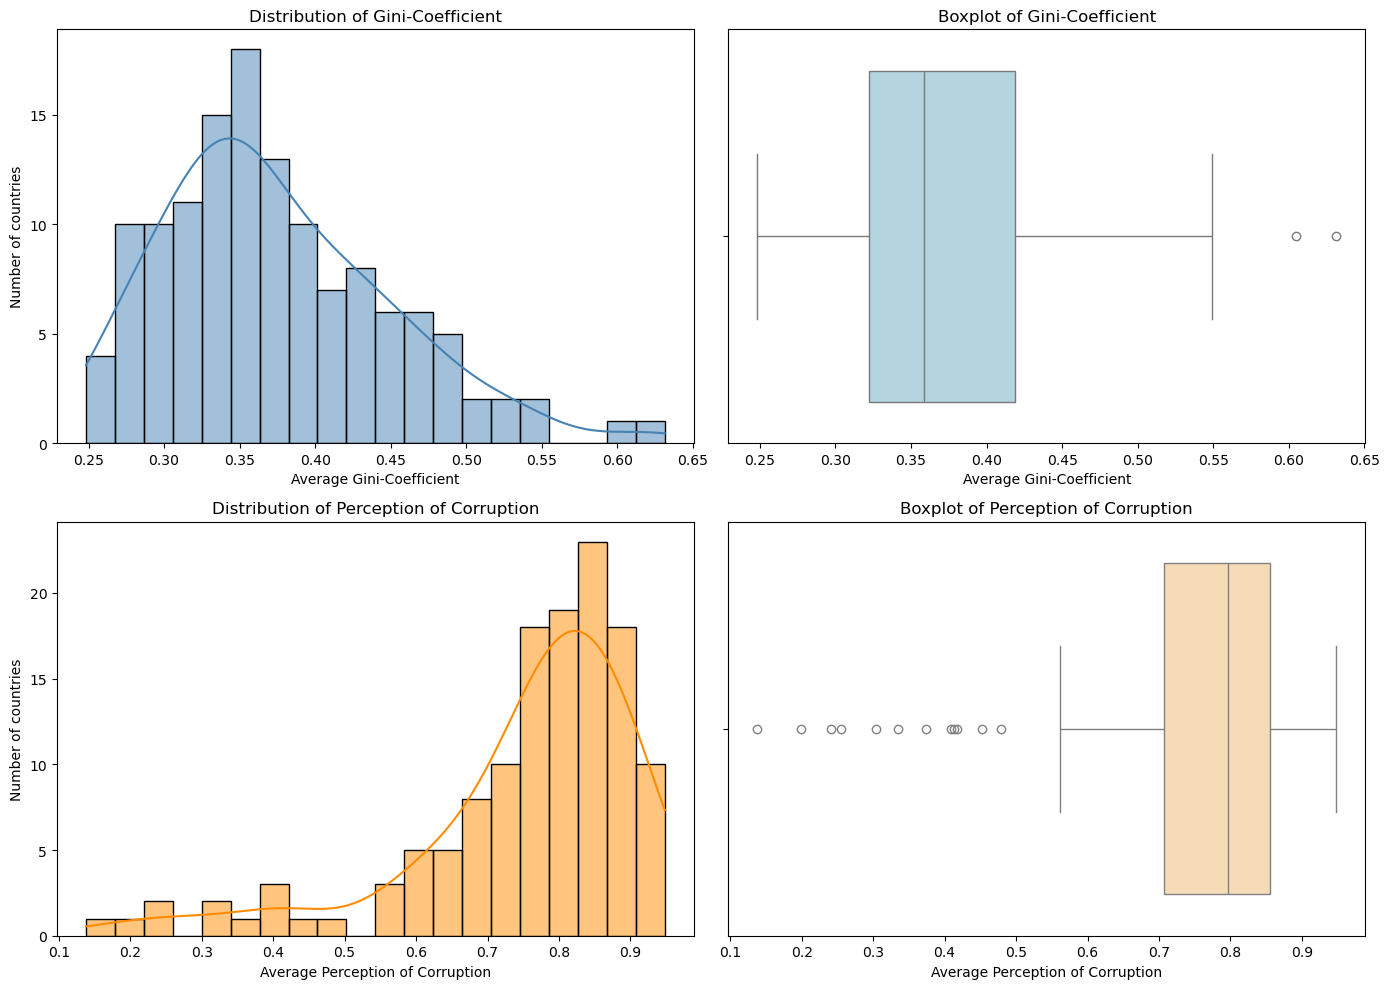

Gini coefficient outliers:
Country name  Gini coefficient (2021 prices)
South Africa                        0.631391
       Haiti                        0.604508

Perceptions of corruption outliers:
  Country name  Perceptions of corruption
United Kingdom                   0.479071
       Ireland                   0.452357
        Canada                   0.417746
   Netherlands                   0.413667
     Australia                   0.408430
    Luxembourg                   0.374566
        Norway                   0.334880
   Switzerland                   0.304179
        Sweden                   0.255248
       Finland                   0.241205
       Denmark                   0.198935
        Rwanda                   0.137883


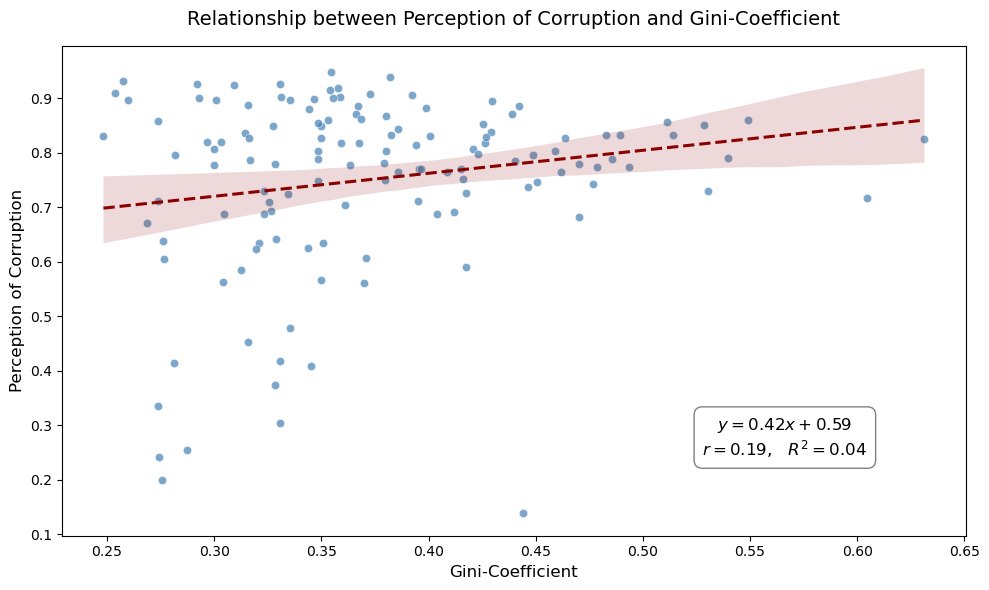

Regression equation: y = 0.422x + 0.594
Correlation (r): 0.194
R-squared (R²): 0.038
P-value: 0.0261
✅ The relationship is statistically significant (p < 0.05).


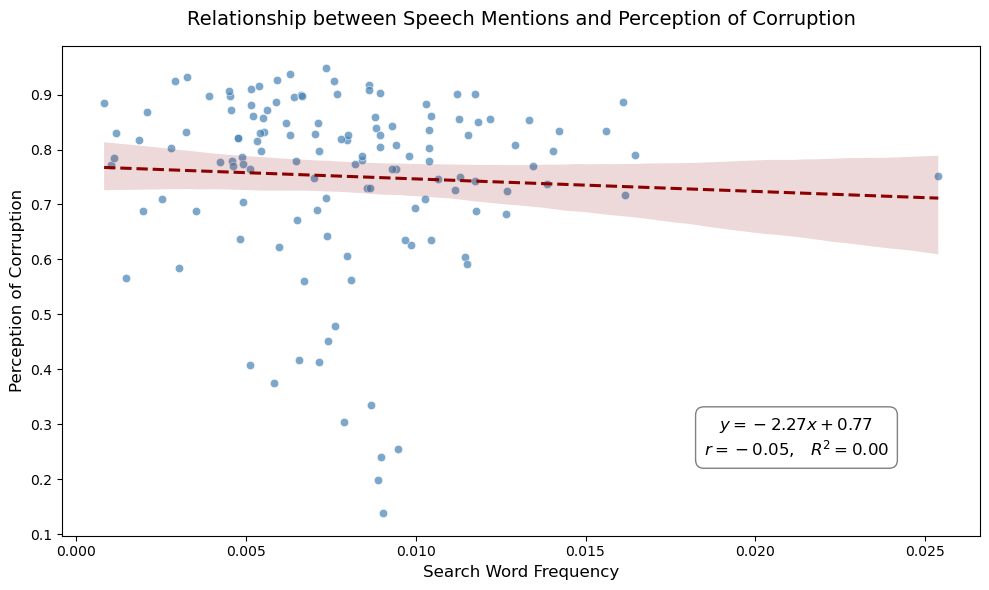

Regression equation: y = -2.274x + 0.769
Correlation (r): -0.052
R-squared (R²): 0.003


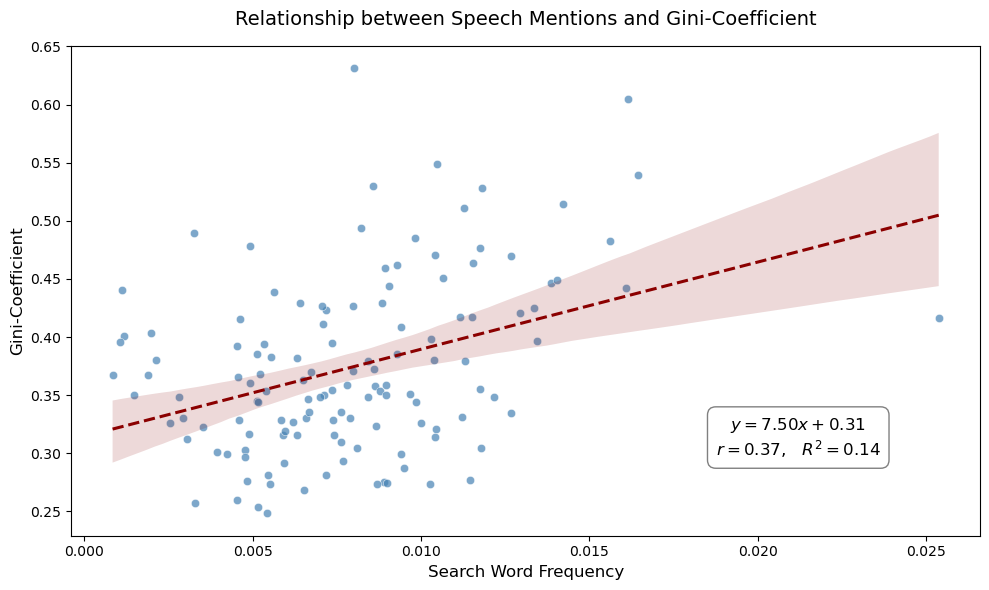

Regression equation: y = 7.495x + 0.315
Correlation (r): 0.375
R-squared (R²): 0.140


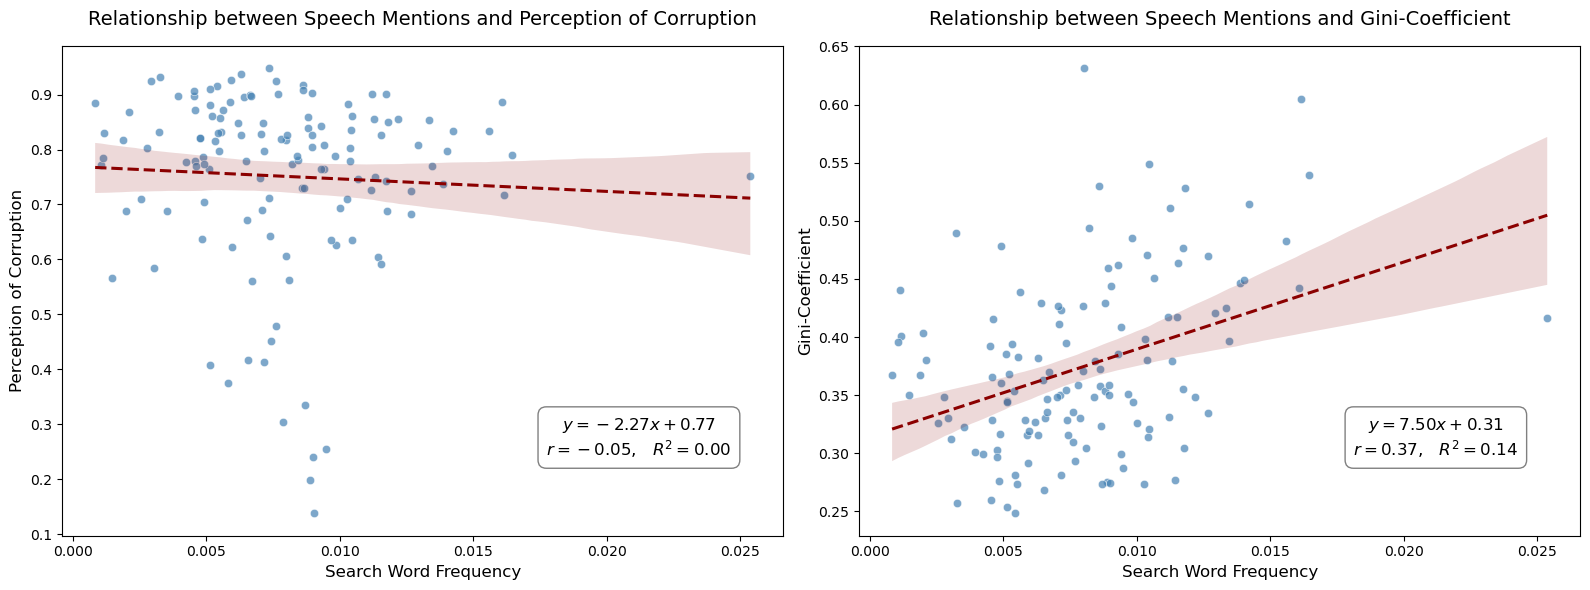

Search Words Frequency vs Perceptions of Corruption
Regression equation: y = -2.274x + 0.769
Correlation (r): -0.052
R-squared (R²): 0.003

=== Search Words Frequency vs Gini Coefficient ===
Regression equation: y = 7.495x + 0.315
Correlation (r): 0.375
R-squared (R²): 0.140
Correlation (r) of Perception of Corruption: -0.052, p-value of Perception of Corruption: 0.553
Correlation (r) of Gini-Coefficient: 0.375, p-value of Gini-Coefficient: 0.000


In [ ]:
# Section 5 - EDA Analysis
# Average per country
avg_df = (
    df_master
    .dropna(subset=["Gini coefficient (2021 prices)", "Perceptions of corruption", "Search Words Frequency"])
    .groupby("Country name", as_index=False)[["Gini coefficient (2021 prices)", "Perceptions of corruption", "Search Words Frequency"]]
    .mean()
)

# DESCRIPTIVE STATISTICS WITH DISTRIBUTIONS 
plt.figure(figsize=(14, 10))

# --- Histogram for Gini ---
plt.subplot(2, 2, 1)
sns.histplot(avg_df["Gini coefficient (2021 prices)"], bins=20, kde=True, color="steelblue")
plt.title("Distribution of Gini-Coefficient")
plt.xlabel("Average Gini-Coefficient")
plt.ylabel("Number of countries")
plt.yticks(range(0, 20, 5))

# --- Boxplot for Gini ---
plt.subplot(2, 2, 2)
sns.boxplot(x=avg_df["Gini coefficient (2021 prices)"], color="lightblue")
plt.title("Boxplot of Gini-Coefficient")
plt.xlabel("Average Gini-Coefficient")

# --- Histogram for Perceptions of Corruption ---
plt.subplot(2, 2, 3)
sns.histplot(avg_df["Perceptions of corruption"], bins=20, kde=True, color="darkorange")
plt.title("Distribution of Perception of Corruption")
plt.xlabel("Average Perception of Corruption")
plt.ylabel("Number of countries")

# --- Boxplot for Perceptions of Corruption ---
plt.subplot(2, 2, 4)
sns.boxplot(x=avg_df["Perceptions of corruption"], color="navajowhite")
plt.title("Boxplot of Perception of Corruption")
plt.xlabel("Average Perception of Corruption")

plt.tight_layout()
plt.show()

# --- Outlier detection function (IQR rule) ---
def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[
        (df[column] < lower_bound) | (df[column] > upper_bound)
    ][["Country name", column]]
    
    return outliers.sort_values(column, ascending=False)

# --- Get outliers for Gini and Corruption ---
gini_outliers = get_outliers(avg_df, "Gini coefficient (2021 prices)")
corruption_outliers = get_outliers(avg_df, "Perceptions of corruption")

print("Gini coefficient outliers:")
print(gini_outliers.to_string(index=False))

print("\nPerceptions of corruption outliers:")
print(corruption_outliers.to_string(index=False))

# SCATTERPLOT RELATIONSHIP GINI COEFFICIENT AND PERCEPTION OF CORRUPTION
# --- Linear regression ---
X = avg_df["Gini coefficient (2021 prices)"].values.reshape(-1, 1)
Y = avg_df["Perceptions of corruption"].values

model = LinearRegression(fit_intercept=True)
model.fit(X, Y)

# Statistics
slope = model.coef_[0]
intercept = model.intercept_
r = avg_df["Gini coefficient (2021 prices)"].corr(avg_df["Perceptions of corruption"])
r2 = model.score(X, Y)

# --- Plot ---
plt.figure(figsize=(10, 6))

# Scatterplot
sns.scatterplot(
    data=avg_df,
    x="Gini coefficient (2021 prices)",
    y="Perceptions of corruption",
    color="steelblue",
    alpha=0.7
)

# Regressionline
sns.regplot(
    data=avg_df,
    x="Gini coefficient (2021 prices)",
    y="Perceptions of corruption",
    scatter=False,
    color="darkred",
    line_kws={"linewidth": 2.2, "linestyle": "--"}
)

# --- Regressiondetails (bottom right) ---
details = (
    f"$y = {slope:.2f}x + {intercept:.2f}$\n"
    f"$r = {r:.2f}$,   $R^2 = {r2:.2f}$"
)
plt.text(
    0.8, 0.2, details,                    
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    ha = 'center', 
    va = 'center', 
    bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.5")
)

# --- titles and labels ---
plt.title("Relationship between Perception of Corruption and Gini-Coefficient", fontsize=14, pad=15)
plt.xlabel("Gini-Coefficient", fontsize=12)
plt.ylabel("Perception of Corruption", fontsize=12)

plt.yticks(np.arange(0.1, 1.0, 0.1))

plt.tight_layout()
plt.show()

# --- Print results ---
print(f"Regression equation: y = {slope:.3f}x + {intercept:.3f}")
print(f"Correlation (r): {r:.3f}")
print(f"R-squared (R²): {r2:.3f}")

# --- P-value for correlation significance ---
r_value, p_value = pearsonr(
    avg_df["Gini coefficient (2021 prices)"],
    avg_df["Perceptions of corruption"]
)

print(f"P-value: {p_value:.4f}")

# Optional: quick interpretation
if p_value < 0.05:
    print("✅ The relationship is statistically significant (p < 0.05).")
else:
    print("⚠ The relationship is not statistically significant (p ≥ 0.05).")

# Relationship between Speech-frequencies and Perception of Corruption
# SCATTERPLOT RELATIONSHIP BETWEEN SPEECH MENTIONS AND PERCEPTION OF CORRUPTION
# --- Linear regression ---
X = avg_df["Search Words Frequency"].values.reshape(-1, 1)
Y = avg_df["Perceptions of corruption"].values

model = LinearRegression(fit_intercept=True)
model.fit(X, Y)

# --- Statistics ---
slope = model.coef_[0]
intercept = model.intercept_
r = avg_df["Search Words Frequency"].corr(avg_df["Perceptions of corruption"])
r2 = model.score(X, Y)

# --- Plot ---
plt.figure(figsize=(10, 6))

# Scatterplot
sns.scatterplot(
    data=avg_df,
    x="Search Words Frequency",
    y="Perceptions of corruption",
    color="steelblue",
    alpha=0.7
)

# Regressionline
sns.regplot(
    data=avg_df,
    x="Search Words Frequency",
    y="Perceptions of corruption",
    scatter=False,
    color="darkred",
    line_kws={"linewidth": 2.2, "linestyle": "--"}
)

# --- Regression details (bottom right) ---
details = (
    f"$y = {slope:.2f}x + {intercept:.2f}$\n"
    f"$r = {r:.2f}$,   $R^2 = {r2:.2f}$"
)
plt.text(
    0.8, 0.2, details,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    ha='center',
    va='center',
    bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.5")
)

# --- Titles and labels---
plt.title("Relationship between Speech Mentions and Perception of Corruption", fontsize=14, pad=15)
plt.xlabel("Search Word Frequency", fontsize=12)
plt.ylabel("Perception of Corruption", fontsize=12)

plt.yticks(np.arange(0.1, 1.0, 0.1))

plt.tight_layout()
plt.show()

# --- Print results ---
print(f"Regression equation: y = {slope:.3f}x + {intercept:.3f}")
print(f"Correlation (r): {r:.3f}")
print(f"R-squared (R²): {r2:.3f}")

# SCATTERPLOT RELATIONSHIP BETWEEN SEARCH WORD FREQUENCY AND GINI COEFFICIENT
# --- Linear regression ---
X = avg_df["Search Words Frequency"].values.reshape(-1, 1)
Y = avg_df["Gini coefficient (2021 prices)"].values

model = LinearRegression(fit_intercept=True)
model.fit(X, Y)

# --- Statistics ---
slope = model.coef_[0]
intercept = model.intercept_
r = avg_df["Search Words Frequency"].corr(avg_df["Gini coefficient (2021 prices)"])
r2 = model.score(X, Y)

# --- Plot ---
plt.figure(figsize=(10, 6))

# Scatterplot
sns.scatterplot(
    data=avg_df,
    x="Search Words Frequency",
    y="Gini coefficient (2021 prices)",
    color="steelblue",
    alpha=0.7
)

# Regressionline
sns.regplot(
    data=avg_df,
    x="Search Words Frequency",
    y="Gini coefficient (2021 prices)",
    scatter=False,
    color="darkred",
    line_kws={"linewidth": 2.2, "linestyle": "--"}
)

# --- Regression details (bottom right) ---
details = (
    f"$y = {slope:.2f}x + {intercept:.2f}$\n"
    f"$r = {r:.2f}$,   $R^2 = {r2:.2f}$"
)
plt.text(
    0.8, 0.2, details,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    ha='center',
    va='center',
    bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.5")
)

# --- Titles and labels ---
plt.title("Relationship between Speech Mentions and Gini-Coefficient", fontsize=14, pad=15)
plt.xlabel("Search Word Frequency", fontsize=12)
plt.ylabel("Gini-Coefficient", fontsize=12)

# Remove gridlines
plt.grid(False)

plt.tight_layout()
plt.show()

# --- Print results ---
print(f"Regression equation: y = {slope:.3f}x + {intercept:.3f}")
print(f"Correlation (r): {r:.3f}")
print(f"R-squared (R²): {r2:.3f}")

# COMBINED SCATTERPLOTS: SEARCH WORD FREQUENCY VS PERCEPTIONS OF CORRUPTION & GINI COEFFICIENT
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # two subplots side by side

# (1) Search Words Frequency vs Perceptions of Corruption
X1 = avg_df["Search Words Frequency"].values.reshape(-1, 1)
Y1 = avg_df["Perceptions of corruption"].values

model1 = LinearRegression(fit_intercept=True)
model1.fit(X1, Y1)

slope1 = model1.coef_[0]
intercept1 = model1.intercept_
r1 = avg_df["Search Words Frequency"].corr(avg_df["Perceptions of corruption"])
r2_1 = model1.score(X1, Y1)

sns.scatterplot(
    ax=axes[0],
    data=avg_df,
    x="Search Words Frequency",
    y="Perceptions of corruption",
    color="steelblue",
    alpha=0.7
)

sns.regplot(
    ax=axes[0],
    data=avg_df,
    x="Search Words Frequency",
    y="Perceptions of corruption",
    scatter=False,
    color="darkred",
    line_kws={"linewidth": 2.2, "linestyle": "--"}
)

details1 = (
    f"$y = {slope1:.2f}x + {intercept1:.2f}$\n"
    f"$r = {r1:.2f}$,   $R^2 = {r2_1:.2f}$"
)
axes[0].text(
    0.8, 0.2, details1,
    transform=axes[0].transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    ha='center',
    va='center',
    bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.5")
)

axes[0].set_title("Relationship between Speech Mentions and Perception of Corruption", fontsize=14, pad=15)
axes[0].set_xlabel("Search Word Frequency", fontsize=12)
axes[0].set_ylabel("Perception of Corruption", fontsize=12)
axes[0].set_yticks(np.arange(0.1, 1.0, 0.1))
axes[0].grid(False)

# (2) Search Words Frequency vs Gini Coefficient
X2 = avg_df["Search Words Frequency"].values.reshape(-1, 1)
Y2 = avg_df["Gini coefficient (2021 prices)"].values

model2 = LinearRegression(fit_intercept=True)
model2.fit(X2, Y2)

slope2 = model2.coef_[0]
intercept2 = model2.intercept_
r2 = avg_df["Search Words Frequency"].corr(avg_df["Gini coefficient (2021 prices)"])
r2_2 = model2.score(X2, Y2)

sns.scatterplot(
    ax=axes[1],
    data=avg_df,
    x="Search Words Frequency",
    y="Gini coefficient (2021 prices)",
    color="steelblue",
    alpha=0.7
)

sns.regplot(
    ax=axes[1],
    data=avg_df,
    x="Search Words Frequency",
    y="Gini coefficient (2021 prices)",
    scatter=False,
    color="darkred",
    line_kws={"linewidth": 2.2, "linestyle": "--"}
)

details2 = (
    f"$y = {slope2:.2f}x + {intercept2:.2f}$\n"
    f"$r = {r2:.2f}$,   $R^2 = {r2_2:.2f}$"
)
axes[1].text(
    0.8, 0.2, details2,
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment='bottom',
    horizontalalignment='right',
    ha='center',
    va='center',
    bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.5")
)

axes[1].set_title("Relationship between Speech Mentions and Gini-Coefficient", fontsize=14, pad=15)
axes[1].set_xlabel("Search Word Frequency", fontsize=12)
axes[1].set_ylabel("Gini-Coefficient", fontsize=12)
axes[1].grid(False)

plt.tight_layout()
plt.show()

# Print results
print("Search Words Frequency vs Perceptions of Corruption")
print(f"Regression equation: y = {slope1:.3f}x + {intercept1:.3f}")
print(f"Correlation (r): {r1:.3f}")
print(f"R-squared (R²): {r2_1:.3f}")

print("\n=== Search Words Frequency vs Gini Coefficient ===")
print(f"Regression equation: y = {slope2:.3f}x + {intercept2:.3f}")
print(f"Correlation (r): {r2:.3f}")
print(f"R-squared (R²): {r2_2:.3f}")

# STATISTICAL SIGNIFICANCE
from scipy.stats import pearsonr

# Example 1: Search Word Frequency vs. Perception of Corruption
r, p_value = pearsonr(avg_df["Search Words Frequency"], avg_df["Perceptions of corruption"])
print(f"Correlation (r) of Perception of Corruption: {r:.3f}, p-value of Perception of Corruption: {p_value:.3f}")

# Example 2: Search Word Frequency vs. Gini Coefficient
r_gini, p_value_gini = pearsonr(avg_df["Search Words Frequency"], avg_df["Gini coefficient (2021 prices)"])
print(f"Correlation (r) of Gini-Coefficient: {r_gini:.3f}, p-value of Gini-Coefficient: {p_value_gini:.3f}")

In [6]:
# WORLD MAP
# --- Compute average corruption ---
avg_corruption = (
    merged_df
    # .query("2008 <= Year <= 2023")
    .dropna(subset=["Perceptions of corruption"])
    .groupby(["Country name", "ISO-alpha3 Code"], as_index=False)["Perceptions of corruption"]
    .mean()
)

# --- Compute average Gini (2008–2023 only) ---
avg_gini = (
    merged_df
    # .query("2008 <= Year <= 2023")
    .dropna(subset=["Gini coefficient (2021 prices)"])
    .groupby(["Country name", "ISO-alpha3 Code"], as_index=False)["Gini coefficient (2021 prices)"]
    .mean()
)

# --- Fix non-standard ISO codes ---
for df in [avg_corruption, avg_gini]:
    df["ISO-alpha3 Code"] = df["ISO-alpha3 Code"].replace({
        "OWID_KOS": "XKX",
        "OWID_TWN": "TWN"
    })
    df.dropna(subset=["ISO-alpha3 Code"], inplace=True)
    df = df[df["ISO-alpha3 Code"].str.len() == 3]

# --- Quick preview (optional) ---
print("Corruption dataframe:", avg_corruption.shape)
print("Gini dataframe:", avg_gini.shape)

# --- OPTIONAL: Single corruption map preview ---
fig_single = px.choropleth(
    avg_corruption,
    locations="ISO-alpha3 Code",
    color="Perceptions of corruption",
    hover_name="Country name",
    projection="natural earth",
    color_continuous_scale="RdYlGn_r",
    title="Average Perception of Corruption per country"
)
fig_single.show(renderer="browser")

# --- Create subplot with 2 maps ---
fig = sp.make_subplots(
    rows=1, cols=2,
    subplot_titles=("Perception of Corruption", "Gini-Coefficient"),
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]]
)

# --- Corruption map (stretched scale for better contrast) ---
fig.add_trace(
    go.Choropleth(
        locations=avg_corruption["ISO-alpha3 Code"],
        z=avg_corruption["Perceptions of corruption"],
        text=avg_corruption["Country name"],
        colorscale="Blues",
        colorbar=dict(
            title="Corruption<br>(higher = more corrupt)",
            orientation="h",
            x=0.25,
            y=-0.05,
            len=0.35
        ),
        zmin=0.65,  # adjust as needed
        zmax=0.95,
    ),
    row=1, col=1
)

# --- Gini map (natural range) ---
fig.add_trace(
    go.Choropleth(
        locations=avg_gini["ISO-alpha3 Code"],
        z=avg_gini["Gini coefficient (2021 prices)"],
        text=avg_gini["Country name"],
        colorscale="Blues",
        colorbar=dict(
            title="Income Inequality<br>(higher = more unequal)",
            orientation="h",
            x=0.75,
            y=-0.05,
            len=0.35
        ),
        zmin=avg_gini["Gini coefficient (2021 prices)"].min(),
        zmax=avg_gini["Gini coefficient (2021 prices)"].max(),
    ),
    row=1, col=2
)

# --- Layout ---
fig.update_layout(
    title_text="Perception of Corruption and Gini-Coefficient across countries",
    title_x=0.5,
    geo=dict(projection_type="natural earth"),
    geo2=dict(projection_type="natural earth"),
    width=1200,
    height=600,
    margin=dict(l=20, r=20, t=60, b=70)
)

# --- Adjust subplot subtitles ---
for annotation in fig['layout']['annotations']:
    annotation['y'] -= 0.08
    annotation['yanchor'] = "top"

# --- Show interactive ---
fig.show(renderer="browser")

# --- Save static PNG (requires kaleido) ---
fig.write_image("corruption_gini_polished.png", scale=3, width=1600, height=700)

Corruption dataframe: (159, 3)
Gini dataframe: (135, 3)


The analysis reveals no significant association between word frequency and perceived corruption (r = –0.05, p = 0.553). In contrast, a moderate and statistically significant positive relationship is observed between word frequency and income inequality (r = 0.38, p < 0.001). This finding suggests that countries referencing corruption- and income inequality-related terms more frequently in political discourse tend to experience higher levels of income inequality. As the p-value is below the 0.05 threshold, the data provide statistically significant evidence that this relationship is unlikely to have occurred by chance. Given the significant positive association between these mentions and the Gini-Coefficient, and the weak but positive correlation between the Gini-Coefficient and Perception of Corruption, there is some evidence to partially support the original hypothesis.

### **Predictive research question:** Can we predict a country’s degree of economic inequality from language used in its political speeches? 
##### **Hypothesis:** A country’s degree of economic inequality can be predicted from the words in its political speeches.

In [7]:
# Section 5 - Predictive question analysis - all words
# Model for speeches and perception of corruption
df_clean = df_master.dropna(subset=["Clean Speech","Perceptions of corruption"]).loc[:,:][["Clean Speech","Perceptions of corruption"]]
df_clean["Clean Speech"] = df_clean["Clean Speech"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
X = df_clean["Clean Speech"]
y = df_clean["Perceptions of corruption"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

# Pipeline
text_reg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('reg', Ridge())
])

# Grid of hyperparameters
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__max_df': [0.75, 0.85, 1.0],
    'vect__min_df': [1, 5],
    'tfidf__use_idf': [True, False],
    'reg__alpha': [0.1, 1.0, 10.0]
}

# GridSearch
grid = GridSearchCV(text_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluate
print("Model for predicting Perception of Corruption based on Speeches:")
print("Best params:", grid.best_params_)
y_pred = grid.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2:", r2_score(y_test, y_pred))


# Model for speeches and Gini-Coefficient
df_clean = df_master.dropna(subset=["Clean Speech","Gini coefficient (2021 prices)"]).loc[:,:][["Clean Speech","Gini coefficient (2021 prices)"]]
df_clean["Clean Speech"] = df_clean["Clean Speech"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
X = df_clean["Clean Speech"]
y = df_clean["Gini coefficient (2021 prices)"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

# Pipeline
text_reg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('reg', Ridge())
])

# Grid of hyperparameters
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__max_df': [0.75, 0.85, 1.0],
    'vect__min_df': [1, 5],
    'tfidf__use_idf': [True, False],
    'reg__alpha': [0.1, 1.0, 10.0]
}

# GridSearch
grid = GridSearchCV(text_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluate
print("Model for predicting Gini-Coefficient based on Speeches:")
print("Best params:", grid.best_params_)
y_pred = grid.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2:", r2_score(y_test, y_pred))

Model for predicting Perception of Corruption based on Speeches:
Best params: {'reg__alpha': 0.1, 'tfidf__use_idf': True, 'vect__max_df': 0.75, 'vect__min_df': 1, 'vect__ngram_range': (1, 1)}


C:\Users\mboer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Test RMSE: 0.10697564491900234
Test R^2: 0.6477478790604512
Model for predicting Gini-Coefficient based on Speeches:
Best params: {'reg__alpha': 0.1, 'tfidf__use_idf': True, 'vect__max_df': 1.0, 'vect__min_df': 1, 'vect__ngram_range': (1, 1)}
Test RMSE: 0.03303627424197261
Test R^2: 0.8148922512110722


C:\Users\mboer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [8]:
# Section 5 - Predictive question analysis - subset of words
# Correct search term syntax for use in model:
corruption_terms = [
    "transparency", "transparent", "accountable", "accountability", "ethic", "ethics", "ethical", "checks and balances", "corrupt", "corruption", 
    "corrupted", "corruptible", "corrupts", "corrupting", "bribe", "bribery", "bribed", "bribes", "bribing", "kickback", "embezzle", "embezzles", 
    "embezzlement", "embezzled", "embezzling", "fraud", "fraudulent", "misappropriate", "misappropriation", "misappropriated", "misappropriates", 
    "peculate", "peculation", "peculated", "launder", "laundering", "illegal funds", "illegal funding", "illegal financing", "illegal finance", 
    "illicit", "tax evasion", "tax evade", "tax avoid", "tax avoidance", "hidden asset", "hidden assets", "offshore account", "offshore accounts", 
    "offshore company", "offshore companies", "shell company", "shell companies", "laundered", "launders", "laundering", "secret banking", 
    "banking secrecy", "asset recovery", "stolen assets", "abuse", "malfeasance", "misconduct", "breach of trust", "dereliction of duty", 
    "undue influence", "conflict of interest", "conflict of interests", "state capture", "patronage", "rent-seeking", "influence peddling", "crony", 
    "cronies", "cronyism", "nepotist", "nepotism", "nepotists", "favoritism", "clientelism", "tribalist", "tribalism", "tribalists", "poor governance", 
    "bad governance", "good governance", "rule of law", "strengthening institutions", "public sector reform", "institutional reform", "racketeering", 
    "racketeer", "racketeers", "extort", "extortion", "extorted", "extorting", "black market", "smuggle", "smuggler", "smuggles", "smuggling", 
    "collude", "collusion", "colluded", "colludes", "colluding", "cartel", "UNCAC", "financial action task force", "FATF", 
    "national anti-corruption commission", "integrity commission", "trafficking", "traffic", "trafficker", "traffics", "trafficked"
]

economic_inequality_terms = [
    "inequal", "inequality", "equal", "equality", "equity", "equitable", "gap", "divide", "disparity", "disparities", "inequitable", "inequity", 
    "poverty", "destitute", "destitution", "deprive", "deprivation", "deprived", "underprivilege", "underprivileged", "marginalize", "marginalized", 
    "marginalizes", "exclusion", "exclude", "excluded", "excludes", "excluding", "redistribution", "redistributed", "redistribute", "redistributes", 
    "progressive taxes", "progressive tax", "wealth tax", "wealth taxes", "tax justice", "fiscal justice", "fair taxation", "equitable taxation", 
    "wealth concentration", "capital accumulation", "capital concentration", "wage", "wages", "underemployment", "underemployed", "underemploy", 
    "precarious work", "informal economy", "working poor", "inclusive growth", "equitable growth", "shared prosperity", "equal opportunity", 
    "social mobility", "social justice", "economic justice", "fair growth", "equal distribution", "universal basic income", "social protection", 
    "social safety net", "welfare", "income support", "public assistance", "poverty alleviation", "structural inequality", "structural poverty", 
    "rural-urban divide", "digital divide", "development gap", "north-south divide", "economic polarization", "market concentration", 
    "monopoly power", "oligopoly", "financial exclusion", "right to development", "right to work", "right to social security", "right to housing", 
    "right to education", "equal pay"
]

all_terms = set(corruption_terms)^set(economic_inequality_terms) # Combine sets of search terms

# Ensure removal of stop terms in preprocessed speeches doesn't impact search for terms
stop = set(stopwords.words("english")) # Common stop words: to, and, of
def strip_stopwords_from_term(term):
    tokens = term.lower().split()
    return " ".join([tok for tok in tokens if tok not in stop])

all_terms_cleaned = [
    t for t in (strip_stopwords_from_term(x) for x in all_terms) if t
]

# Model for speeches and perception of corruption
df_clean = df_master.dropna(subset=["Clean Speech","Perceptions of corruption"]).loc[:,:][["Clean Speech","Perceptions of corruption"]]
df_clean["Clean Speech"] = df_clean["Clean Speech"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
X = df_clean["Clean Speech"]
y = df_clean["Perceptions of corruption"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

# Pipeline
text_reg = Pipeline([
    ('vect', CountVectorizer(vocabulary=all_terms_cleaned)), # restrict words here 
    ('tfidf', TfidfTransformer()),
    ('reg', Ridge())
])

# Grid of hyperparameters
param_grid = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'reg__alpha': [0.1, 1.0, 10.0, 100.0]
}

# GridSearch
grid = GridSearchCV(text_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluate
print("Model for predicting Perception of Corruption based on Speeches, only using words of interest:")
print("Best params:", grid.best_params_)
y_pred = grid.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2:", r2_score(y_test, y_pred))

# Model for speeches and Gini-Coefficient
df_clean = df_master.dropna(subset=["Clean Speech","Gini coefficient (2021 prices)"]).loc[:,:][["Clean Speech","Gini coefficient (2021 prices)"]]
df_clean["Clean Speech"] = df_clean["Clean Speech"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
X = df_clean["Clean Speech"]
y = df_clean["Gini coefficient (2021 prices)"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

# Pipeline
text_reg = Pipeline([
    ('vect', CountVectorizer(vocabulary=all_terms_cleaned)), # restrict words here 
    ('tfidf', TfidfTransformer()),
    ('reg', Ridge())
])

# Grid of hyperparameters
param_grid = {
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'reg__alpha': [0.1, 1.0, 10.0, 100.0]
}

# GridSearch
grid = GridSearchCV(text_reg, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluate
print("Model for predicting Gini-Coefficient based on Speeches, only using words of interest:")
print("Best params:", grid.best_params_)
y_pred = grid.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2:", r2_score(y_test, y_pred))

Model for predicting Perception of Corruption based on Speeches, only using words of interest:
Best params: {'reg__alpha': 10.0, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}


C:\Users\mboer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Test RMSE: 0.17599394090082993
Test R^2: 0.04659105453562806
Model for predicting Gini-Coefficient based on Speeches, only using words of interest:
Best params: {'reg__alpha': 1.0, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}
Test RMSE: 0.07051114862692696
Test R^2: 0.15674669380163886


C:\Users\mboer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



These findings suggest that while the supervised machine learning model performs reasonably well when utilizing all words within the speeches, it becomes unreliable in predicting both Perception of Corruption and the Gini-Coeffient when restricted to only the specific related words of interest. There is evidence to support the hypothesis that a country’s degree of economic inequality (as measured by Perception of Corruption and the Gini-Coefficient) can be predicted reasonably well from the language used in its political speeches. This is particularly true for the Gini-Coefficient, which shows a high R Squared (0.815) and a low Mean Square Error (0.033). In contrast, Perception of Corruption exhibits weaker predictive performance, with a lower R Squared and higher Mean Squared Error. While the model performs effectively when using the full dictionary of words contained in the speeches, it fails to predict economic inequality accurately when restricted to corruption- and income inequality-related terms. Given that the exploratory analysis revealed no clear relationship between the frequency of such terms and observed levels of economic inequality, this outcome appears consistent.